<a href="https://www.kaggle.com/code/rautaishwarya/data-cleaning-and-price-prediction?scriptVersionId=138895921" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/samsung-mobiles-latest-dataset/samsung_mobile_new_data.csv
/kaggle/input/samsung-mobiles-latest-dataset/samsungMobilesData.csv


# ** Samsung Mobile Price Pridiction ** # 

## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re 

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load data
df=pd.read_csv("/kaggle/input/samsung-mobiles-latest-dataset/samsung_mobile_new_data.csv")

In [4]:
# Top 5 data points from data
df.head()

,name,ratings,price,imgURL,storage_ram,os_processor,camera,display,network,battery
0,"SAMSUNG Galaxy F13 (Sunrise Copper, 64 GB)",4.3,"₹9,499",https://rukminim2.flixcart.com/image/312/312/x...,Internal Storage64 GBRAM4 GBExpandable Storage...,Operating SystemAndroid 12Processor TypeExynos...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type4G, 3G, 2GSupported Networks4G LTE...",Battery Capacity6000 mAhDual BatteryNo
1,"SAMSUNG Galaxy F13 (Waterfall Blue, 128 GB)",4.3,"₹10,499",https://rukminim2.flixcart.com/image/312/312/x...,Internal Storage128 GBRAM4 GBExpandable Storag...,Operating SystemAndroid 12Processor TypeExynos...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type4G, 3G, 2GSupported Networks4G LTE...",Battery Capacity6000 mAhDual BatteryNo
2,"SAMSUNG Galaxy F13 (Nightsky Green, 128 GB)",4.3,"₹10,499",https://rukminim2.flixcart.com/image/312/312/x...,Internal Storage128 GBRAM4 GBExpandable Storag...,Operating SystemAndroid 12Processor TypeExynos...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type4G, 3G, 2GSupported Networks4G LTE...",Battery Capacity6000 mAhDual BatteryNo
3,"SAMSUNG Galaxy F13 (Sunrise Copper, 128 GB)",4.3,"₹10,499",https://rukminim2.flixcart.com/image/312/312/x...,Internal Storage128 GBRAM4 GBExpandable Storag...,Operating SystemAndroid 12Processor TypeExynos...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type4G, 3G, 2GSupported Networks4G LTE...",Battery Capacity6000 mAhDual BatteryNo
4,"SAMSUNG Galaxy F23 5G (Aqua Blue, 128 GB)",4.3,"₹15,499",https://rukminim2.flixcart.com/image/312/312/x...,Internal Storage128 GBRAM6 GBTotal Memory128 G...,Operating SystemAndroid 12Processor TypeQualco...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type5G, 4G, 3G, 2GSupported Networks5G...",Battery Capacity5000 mAh


In [5]:
# Drop missing values
df.dropna(inplace=True)

# Exploration of each variable (EDA)

## Name

#### Let's extract version, color and capability of mobile from "name" feature.

In [6]:
def parse_product_name(product_name):
    product_name = product_name.strip("'")

    # Define the regular expression pattern to extract version, color, and capability
    pattern = r"(.+) \((.+), (.+)\)"

    # Use the regular expression to find matches in the product name
    match = re.match(pattern, product_name)

    # Check if there's a match and extract the groups (version, color, capability)
    if match:
        version, color, capability = match.groups()
        return version.strip(), color.strip(), capability.strip()
    else:
        return '', '', ''

In [7]:
df[['version', 'color', 'capability']] = df['name'].apply(lambda x: pd.Series(parse_product_name(x)))

In [8]:
# Replace " " with None.
df["capability"]=df["capability"].replace('',"None")

# drop "name" feature
df.drop("name",axis=1,inplace=True)

## Price

#### Remove ₹ and "," from price column.

In [9]:
def clean_price(price):
    price = str(price).replace('₹', '').replace(',', '')
    return price

df['price'] = df['price'].apply(clean_price)


In [10]:
df["price"]=df["price"].astype("int")

## storage_ram   

#### Extract Ram from storage_ram.

In [11]:
df['ram'] = df['storage_ram'].apply(lambda x: int(re.search(r'RAM(\d+)', str(x)).group(1)) if re.search(r'RAM(\d+)', str(x)) else None)

## OS_Processor

#### Extract processor type and clock speed of samsung mobile from os_processor

In [12]:
df['processor_type'] = df['os_processor'].str.extract(r'Processor Type(\w+\s*\w+)')
df['clock_speed'] = df['os_processor'].str.extract(r'Clock Speed([\d.]+\s*GHz)')

In [13]:
# drop columns
df.drop(["os_processor","storage_ram"],axis=1,inplace=True)

In [14]:
df.head()

,ratings,price,imgURL,camera,display,network,battery,version,color,capability,ram,processor_type,clock_speed
0,4.3,9499,https://rukminim2.flixcart.com/image/312/312/x...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type4G, 3G, 2GSupported Networks4G LTE...",Battery Capacity6000 mAhDual BatteryNo,SAMSUNG Galaxy F13,Sunrise Copper,64 GB,4.0,Exynos 850Processor,2 GHz
1,4.3,10499,https://rukminim2.flixcart.com/image/312/312/x...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type4G, 3G, 2GSupported Networks4G LTE...",Battery Capacity6000 mAhDual BatteryNo,SAMSUNG Galaxy F13,Waterfall Blue,128 GB,4.0,Exynos 850Processor,2 GHz
2,4.3,10499,https://rukminim2.flixcart.com/image/312/312/x...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type4G, 3G, 2GSupported Networks4G LTE...",Battery Capacity6000 mAhDual BatteryNo,SAMSUNG Galaxy F13,Nightsky Green,128 GB,4.0,Exynos 850Processor,2 GHz
3,4.3,10499,https://rukminim2.flixcart.com/image/312/312/x...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type4G, 3G, 2GSupported Networks4G LTE...",Battery Capacity6000 mAhDual BatteryNo,SAMSUNG Galaxy F13,Sunrise Copper,128 GB,4.0,Exynos 850Processor,2 GHz
4,4.3,15499,https://rukminim2.flixcart.com/image/312/312/x...,Primary Camera AvailableYesPrimary Camera50MP ...,Display Size16.76 cm (6.6 inch)Resolution2408 ...,"Network Type5G, 4G, 3G, 2GSupported Networks5G...",Battery Capacity5000 mAh,SAMSUNG Galaxy F23 5G,Aqua Blue,128 GB,6.0,Qualcomm Snapdragon,2.2 GHz


#### Replace GHZ and extract clock speed integer

In [15]:
ghz_pattern = r'(\d+(\.\d+)?)\s*GHz'

def extract_ghz_frequency(text):
    ghz_match = re.search(ghz_pattern, str(text))
    return ghz_match.group(1) if ghz_match else None

df["clock_speed"] = df["clock_speed"].apply(extract_ghz_frequency)

## Camera

#### Extract camera quality (MP)

In [16]:
def camera_extract(row):
    if isinstance(row, str):  # Check if row is a string
        row_splitted = row.split()
        pattern = r'\d+MP'
        words = ' '.join(row_splitted)
        find_cam = re.findall(pattern, words)
        return ' '.join(find_cam)
    else:
        return np.nan

In [17]:
df['camera'] = df['camera'].apply(camera_extract)
df["camera"] = df['camera'].str.split(' ').str[0].str.strip()
df["camera"]=df["camera"].str.replace("MP"," ")

In [18]:
df["camera"]=df["camera"].replace('',None)

## Display

#### Extract display resolution, display size and display info

In [19]:
def extract_display_info(display_features):
    start_idx = display_features.find('Display ')
    end_idx = display_features.find('Other Display Features')

    if start_idx != -1 and end_idx != -1:
        display_info = display_features[start_idx + len('Display '):end_idx].strip()
    else:
        display_info = None

    display_size = resolution = type_info = game_support = colors = None

    if display_info is not None:
        size_match = re.search(r'Size([\d.]+ cm \([\d.]+ inch\))', display_info)
        resolution_match = re.search(r'Resolution(\d+ x \d+ Pixels)', display_info)

        display_size = size_match.group(1) if size_match else None
        resolution = resolution_match.group(1) if resolution_match else None

    return display_info, display_size, resolution

df["display_info"], df["display_size"], df["resolution"]= zip(*df["display"].apply(lambda x: extract_display_info(x)))

In [20]:
# drop column
df.drop("display",axis=1,inplace=True)

In [21]:
# Display size in cm and inch
cm_pattern = r'([\d.]+)\s+cm'
inch_pattern = r'([\d.]+)\s+inch'

def extract_display_size(text):
    cm_match = re.search(cm_pattern, str(text))
    inch_match = re.search(inch_pattern, str(text))
    cm_size = cm_match.group(1) if cm_match else None
    inch_size = inch_match.group(1) if inch_match else None
    return cm_size, inch_size

df["display_size_cm"], df["display_size_inch"] = zip(*df["display_size"].apply(extract_display_size))


In [22]:
# drop column
df.drop(["display_info","display_size"],axis=1,inplace=True)

## Battery

### Extract battery capacity

In [23]:
df["battery"]=df["battery"].str.extract(r"Capacity(\d+)")

In [24]:
# drop columns
df.drop(["network","imgURL"],axis=1,inplace=True)

## Color

#### Create color categories for mobile colors

In [25]:
def map_color_to_category(color):
    if 'Blue' in color:
        return 'Blue'
    elif 'Black' in color:
        return 'Black'
    elif 'White' in color:
        return 'Light'
    elif 'Green' in color:
        return 'Green'
    elif 'Red' in color:
        return 'Red'
    elif 'Gold' in color:
        return 'Metallic'
    elif 'Silver' in color:
        return 'Metallic'
    elif 'Purple' in color:
        return 'Violet'
    elif 'Orange' in color:
        return 'Orange'
    elif 'Pink' in color:
        return 'Pink'
    elif 'Yellow' in color:
        return 'Yellow'
    elif 'Gray' in color:
        return 'Gray'
    elif 'Brown' in color:
        return 'Brown'
    elif 'Copper' in color:
        return 'Metallic'
    elif 'Cream' in color:
        return 'Light'
    else:
        return 'Other'

df['color'] = df['color'].apply(map_color_to_category)

In [26]:
df

,ratings,price,camera,battery,version,color,capability,ram,processor_type,clock_speed,resolution,display_size_cm,display_size_inch
0,4.3,9499,50,6000,SAMSUNG Galaxy F13,Metallic,64 GB,4.0,Exynos 850Processor,2,2408 x 1080 Pixels,16.76,6.6
1,4.3,10499,50,6000,SAMSUNG Galaxy F13,Blue,128 GB,4.0,Exynos 850Processor,2,2408 x 1080 Pixels,16.76,6.6
2,4.3,10499,50,6000,SAMSUNG Galaxy F13,Green,128 GB,4.0,Exynos 850Processor,2,2408 x 1080 Pixels,16.76,6.6
3,4.3,10499,50,6000,SAMSUNG Galaxy F13,Metallic,128 GB,4.0,Exynos 850Processor,2,2408 x 1080 Pixels,16.76,6.6
4,4.3,15499,50,5000,SAMSUNG Galaxy F23 5G,Blue,128 GB,6.0,Qualcomm Snapdragon,2.2,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,4.5,21490,32,3500,SAMSUNG Galaxy M40,Blue,128 GB,6.0,NaN,2,None,None,None
570,4.3,104999,108,4500,SAMSUNG Galaxy Note 20 Ultra 5G,Other,256 GB,12.0,Exynos Octa,2.73,None,None,None
571,4.3,16199,25,4000,SAMSUNG Galaxy A30s,Other,64 GB,4.0,Exynos 7904Processor,1.8,None,None,None
572,4.4,9000,13,3300,SAMSUNG Galaxy J4 Plus,Black,32 GB,2.0,Qualcomm Snapdragon,1.4,None,15.24,6


# Graph

In [27]:
# Info 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 0 to 573
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ratings            539 non-null    float64
 1   price              539 non-null    int64  
 2   camera             533 non-null    object 
 3   battery            539 non-null    object 
 4   version            539 non-null    object 
 5   color              539 non-null    object 
 6   capability         539 non-null    object 
 7   ram                525 non-null    float64
 8   processor_type     401 non-null    object 
 9   clock_speed        521 non-null    object 
 10  resolution         111 non-null    object 
 11  display_size_cm    149 non-null    object 
 12  display_size_inch  149 non-null    object 
dtypes: float64(2), int64(1), object(10)
memory usage: 59.0+ KB


# Univariate Analysis

In [28]:
# Categorical coloumn
categorical=df.select_dtypes(include=["object"]).columns

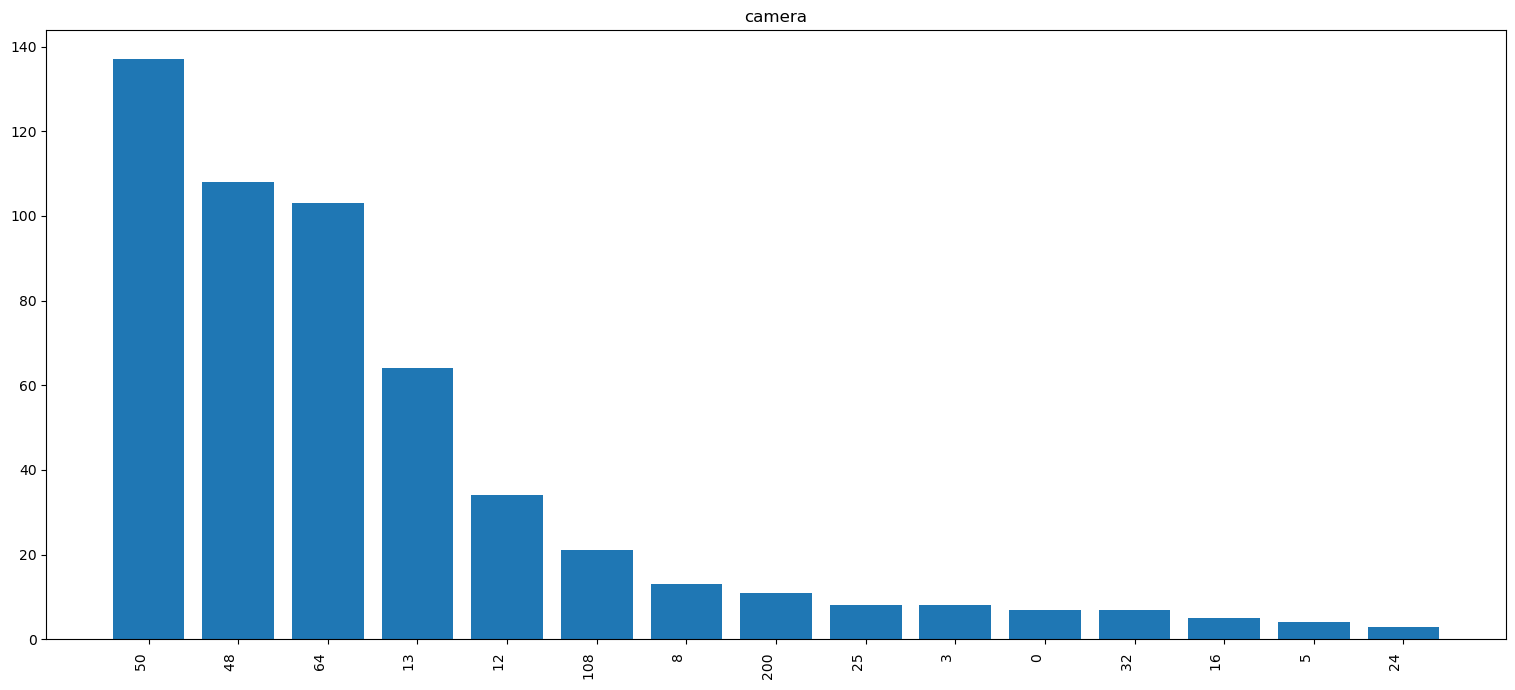

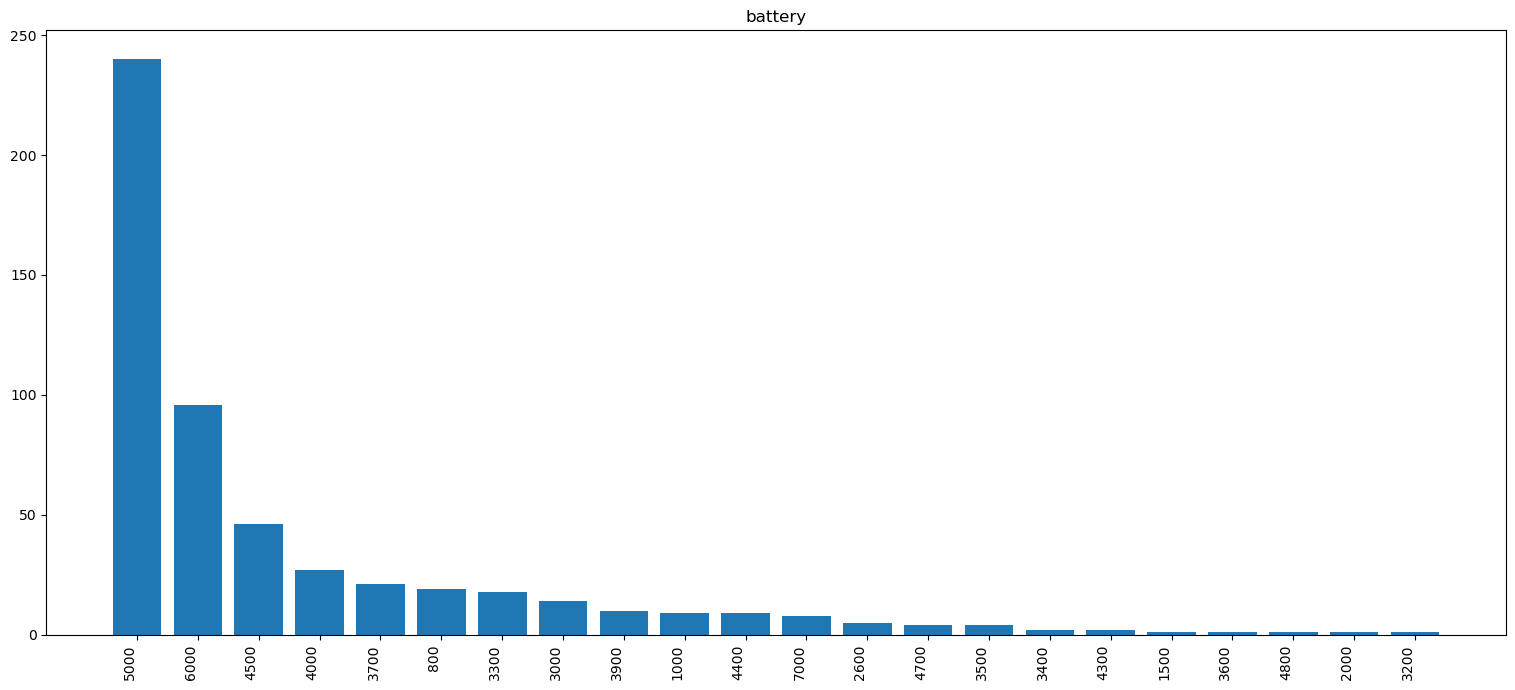

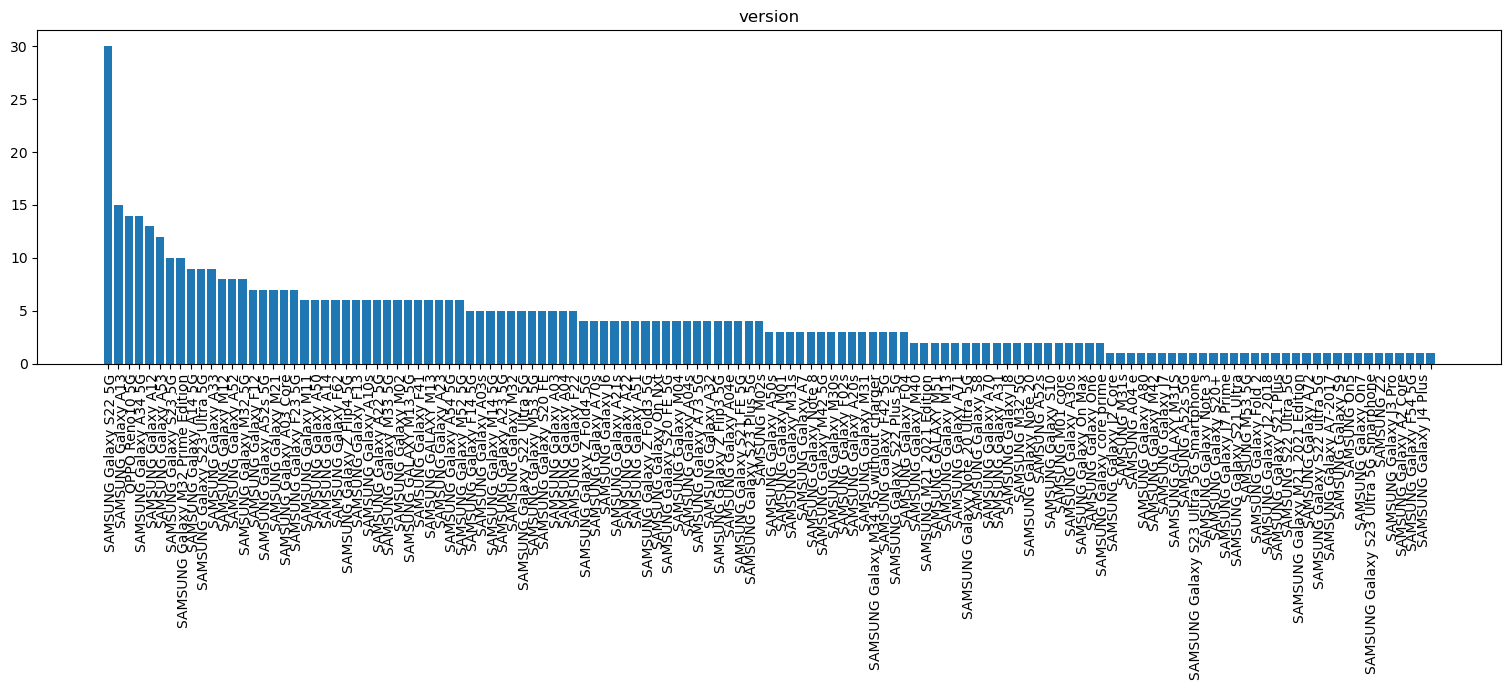

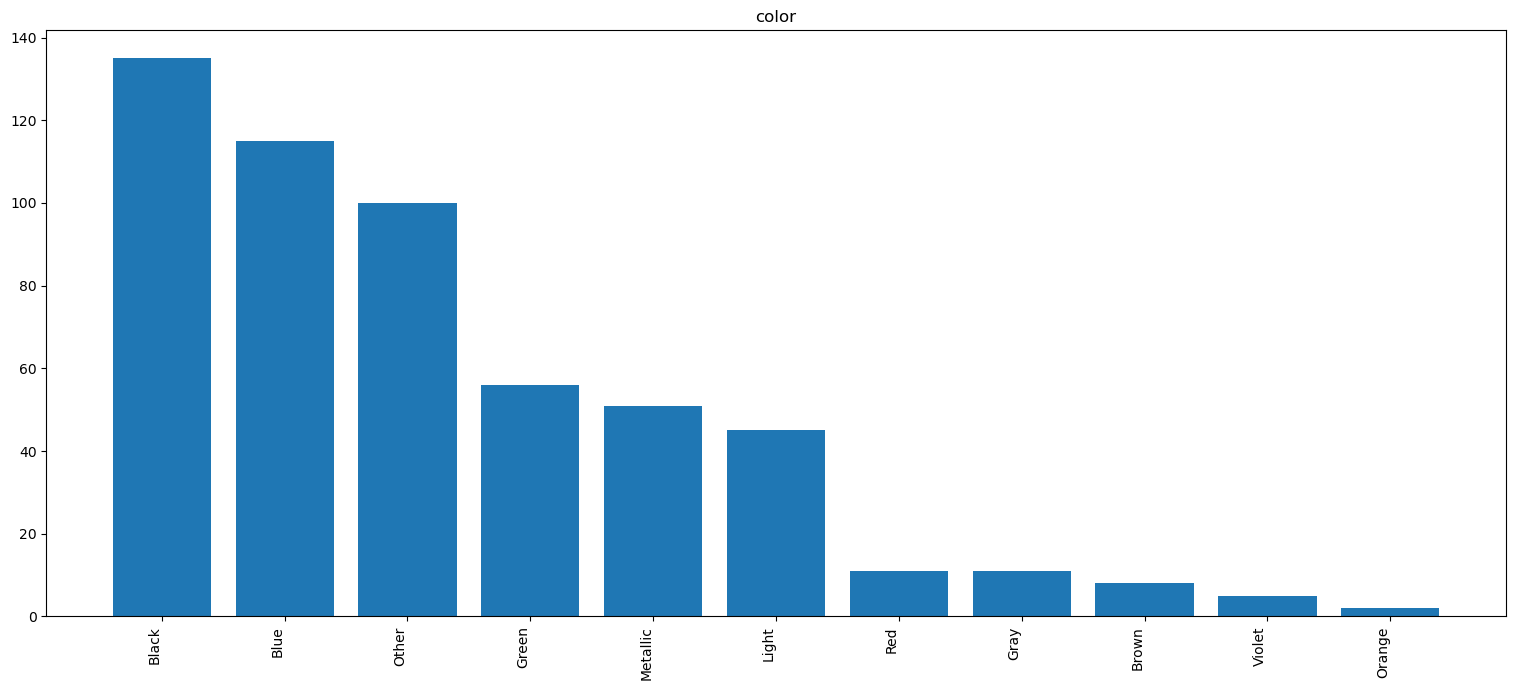

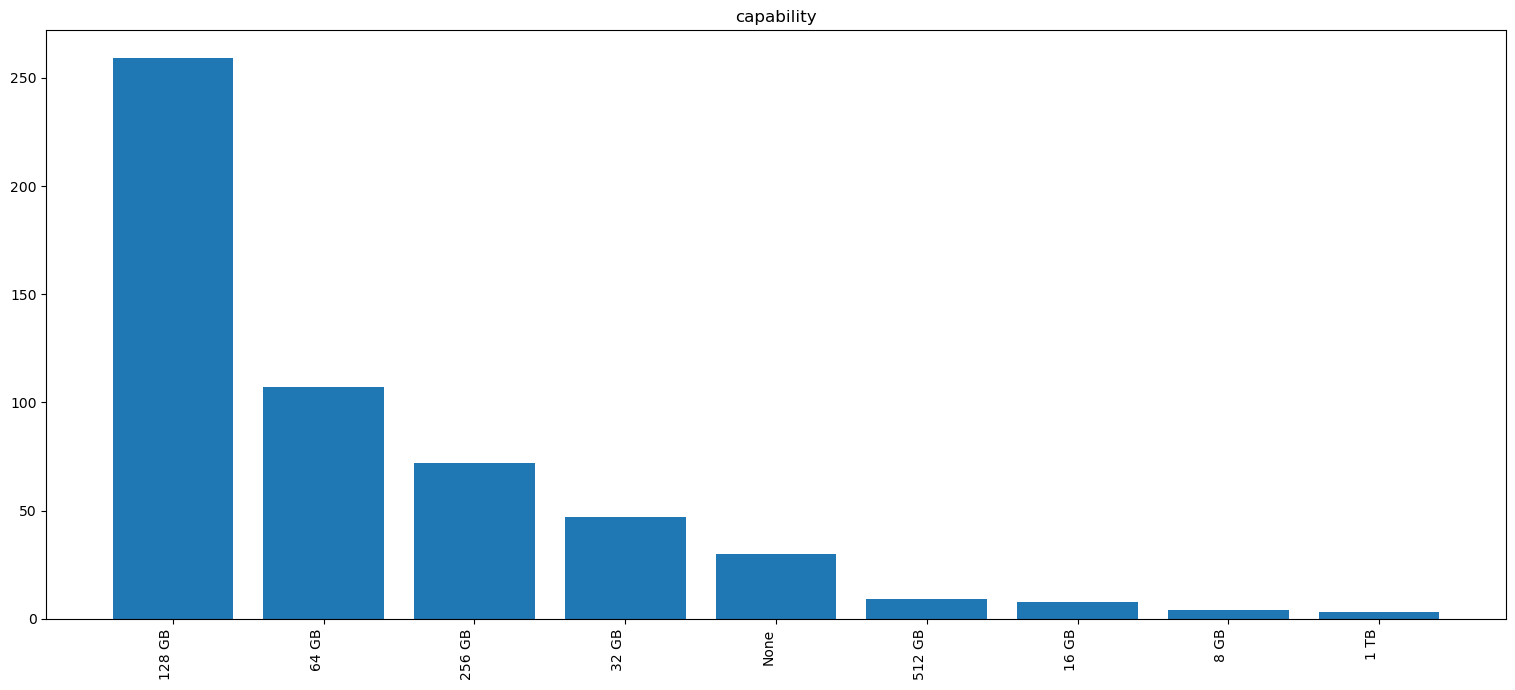

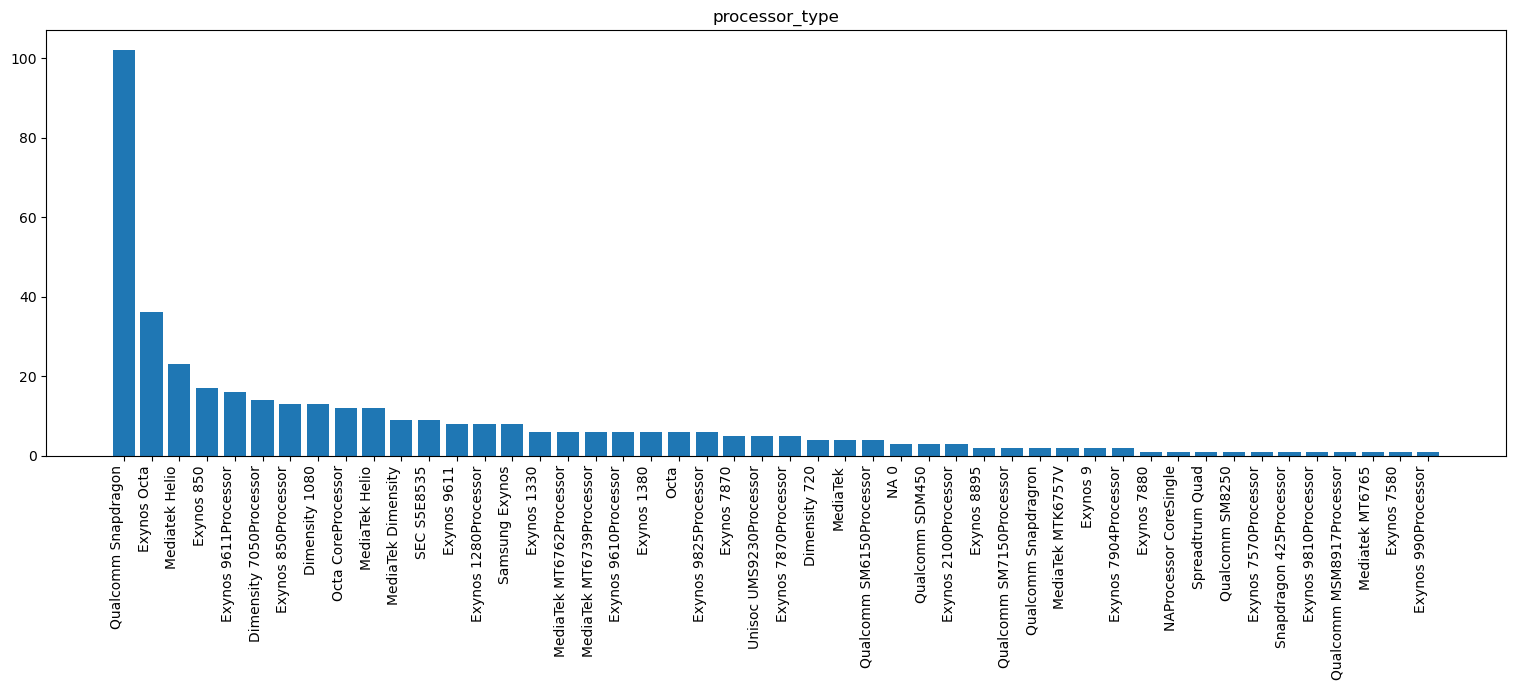

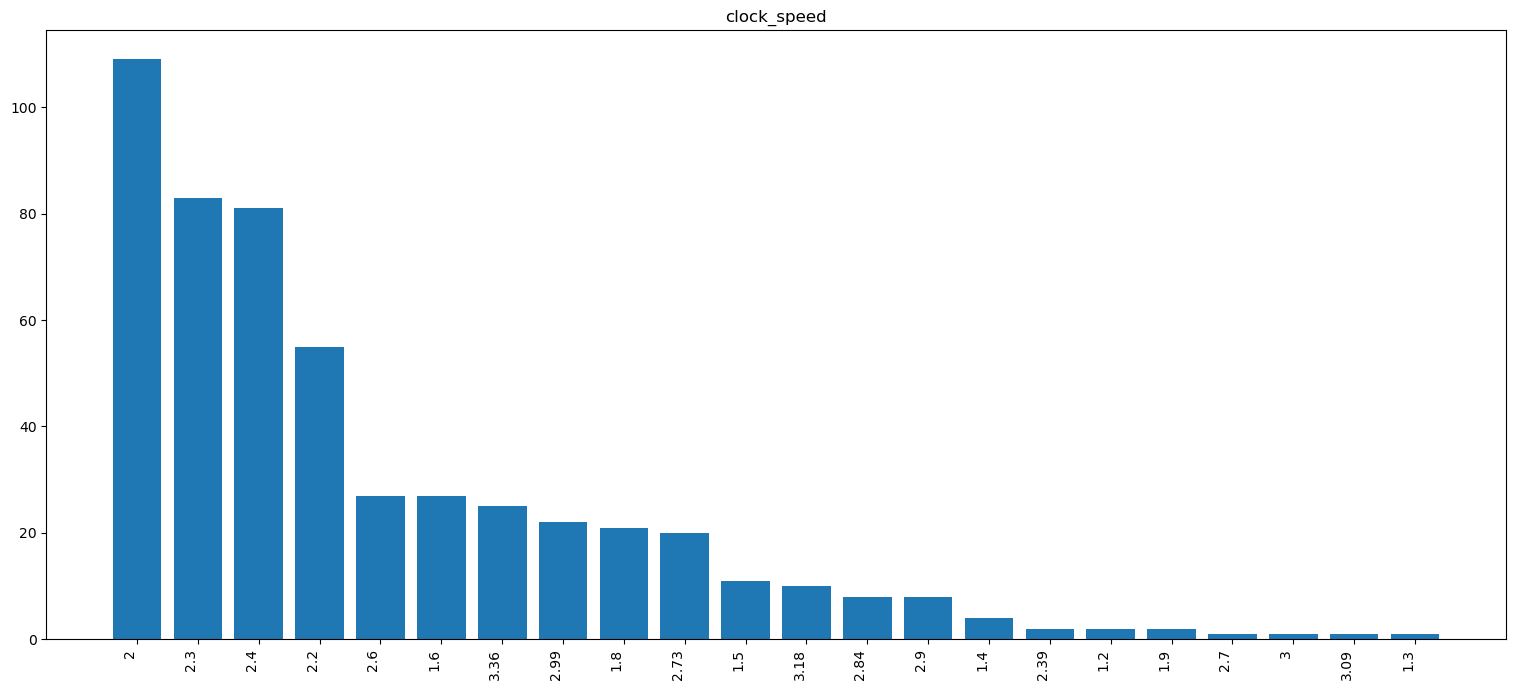

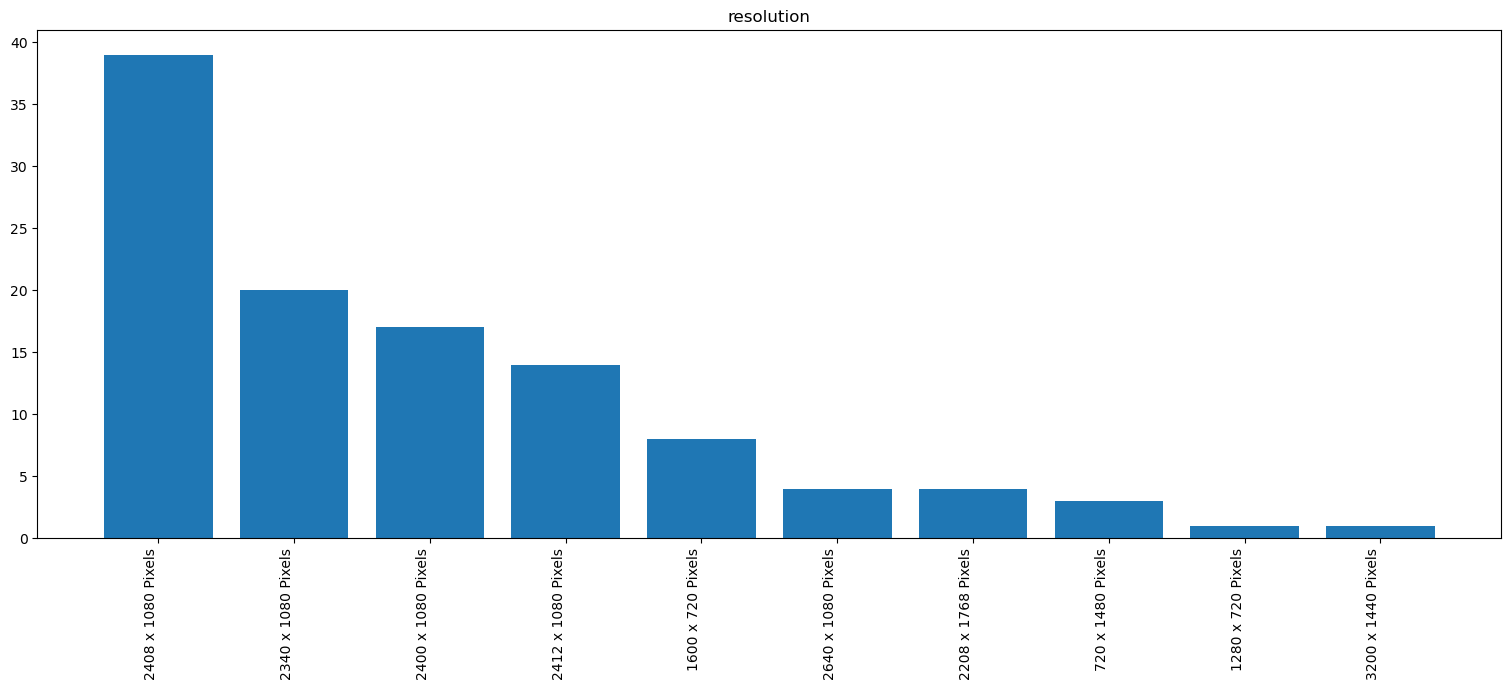

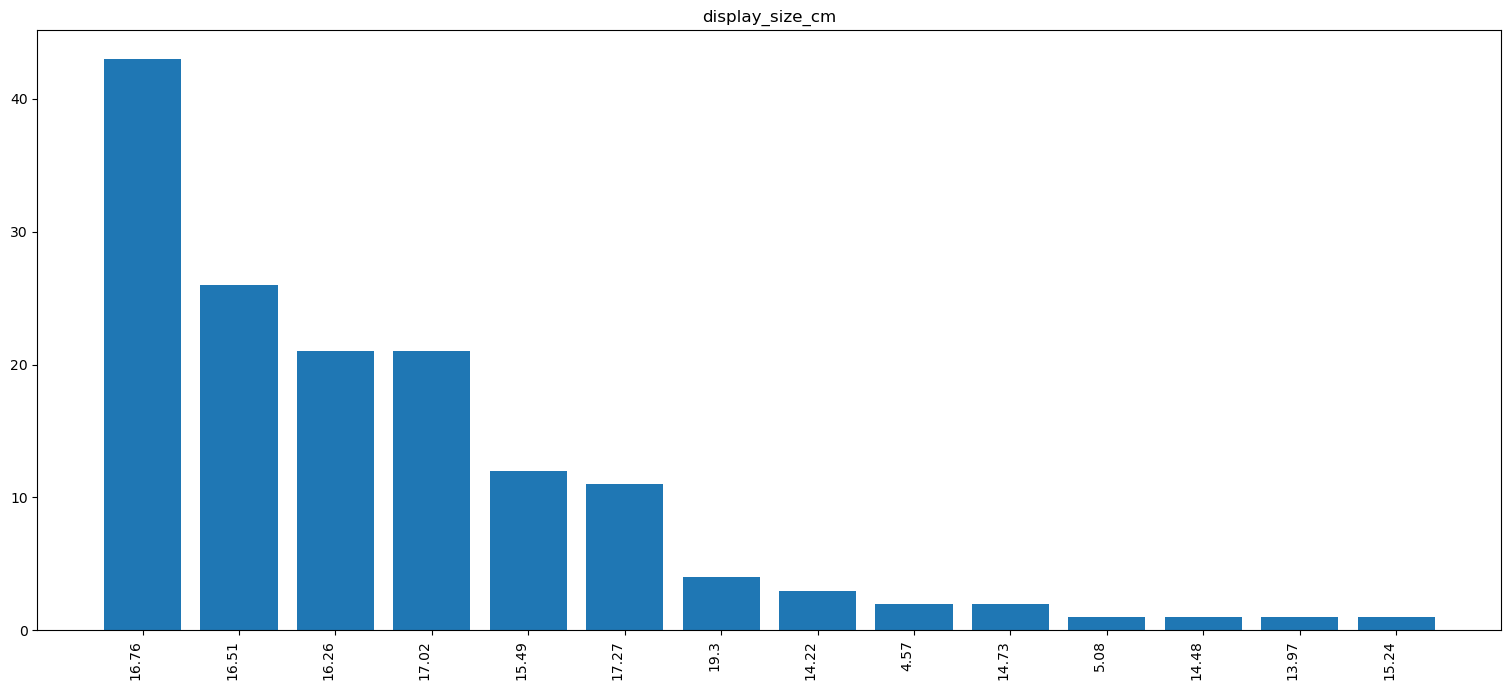

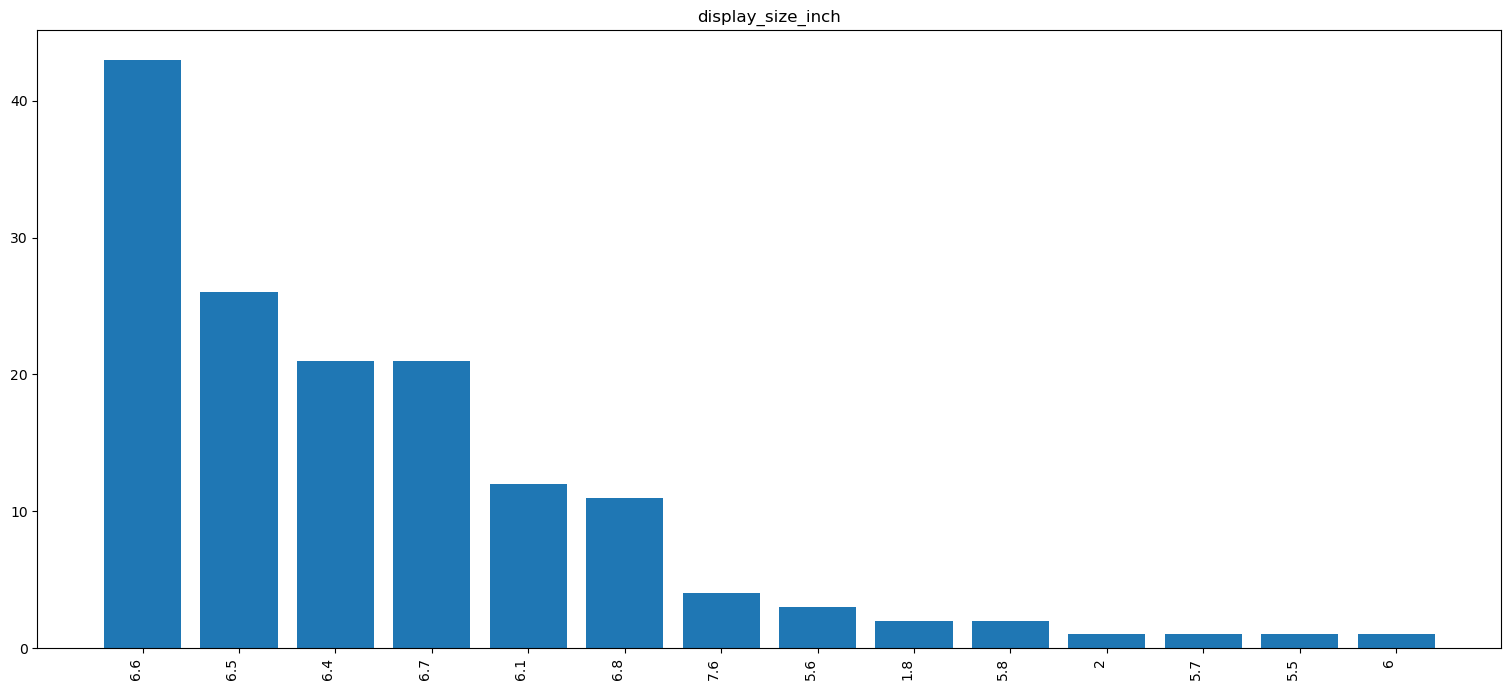

In [29]:
for i in categorical:
    values=df[i].value_counts()    
    plt.figure(figsize=(30,7))
    plt.subplot(121)
    plt.bar(values.index, values.values)
    plt.title(i)
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
plt.show()
    

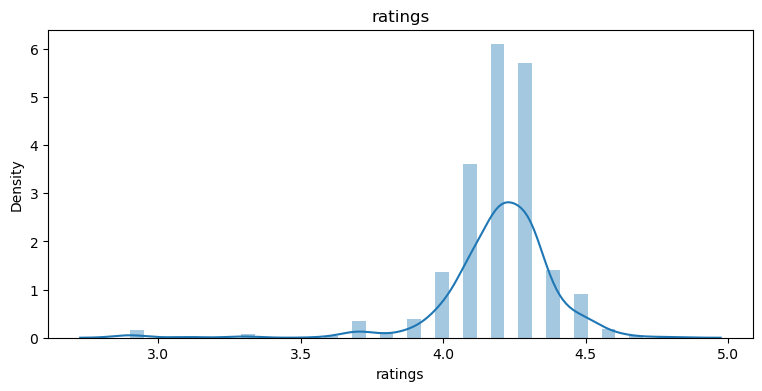

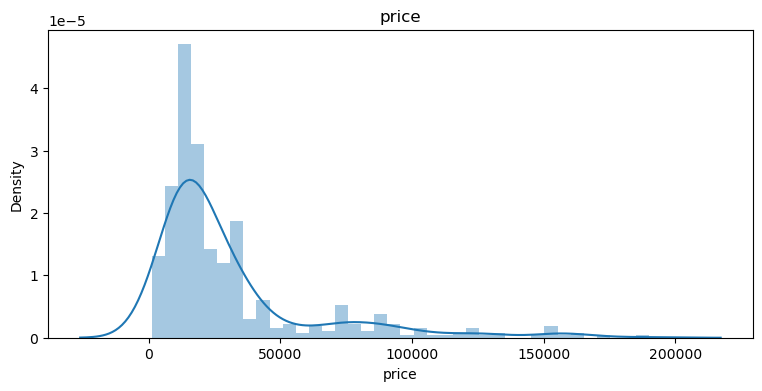

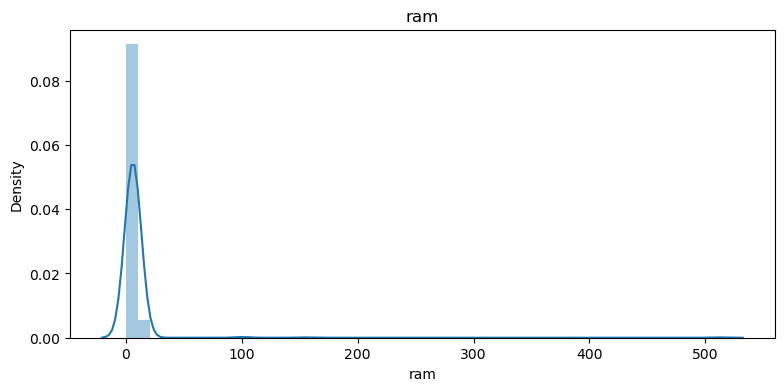

In [30]:
numerical=df.select_dtypes(include=np.number).columns
for i in numerical:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(df[i],kde=True)
    plt.title(i)
plt.show()

# Bivariate Analysis

### Color Vs Price

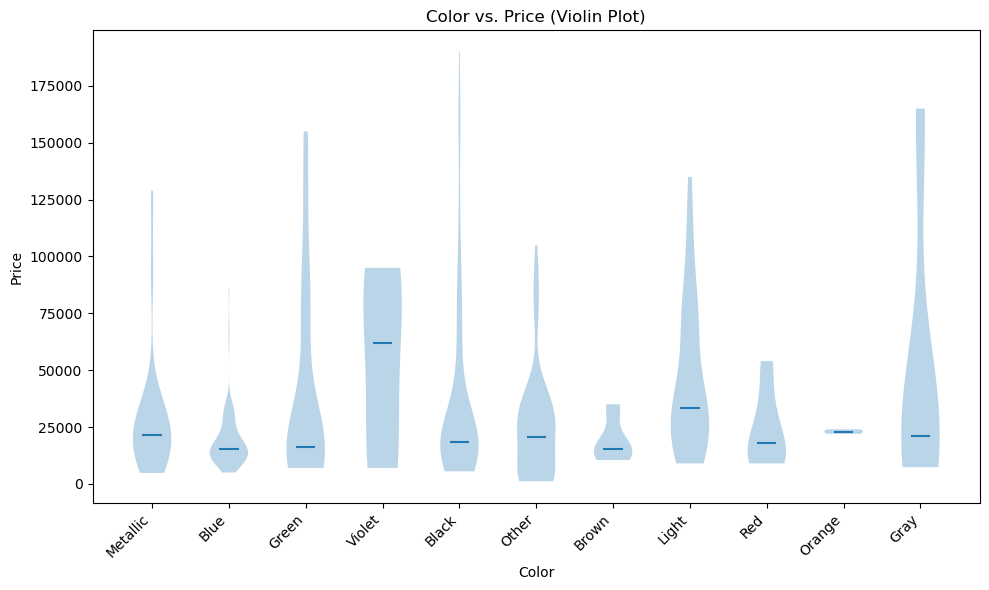

In [31]:
plt.figure(figsize=(10, 6))
plt.violinplot([df[df['color'] == color]['price'] for color in df['color'].unique()],
               showextrema=False, showmedians=True)
plt.xlabel('Color')
plt.ylabel('Price')
plt.title('Color vs. Price (Violin Plot)')
plt.xticks(range(1, len(df['color'].unique()) + 1), df['color'].unique(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Camera Vs Price

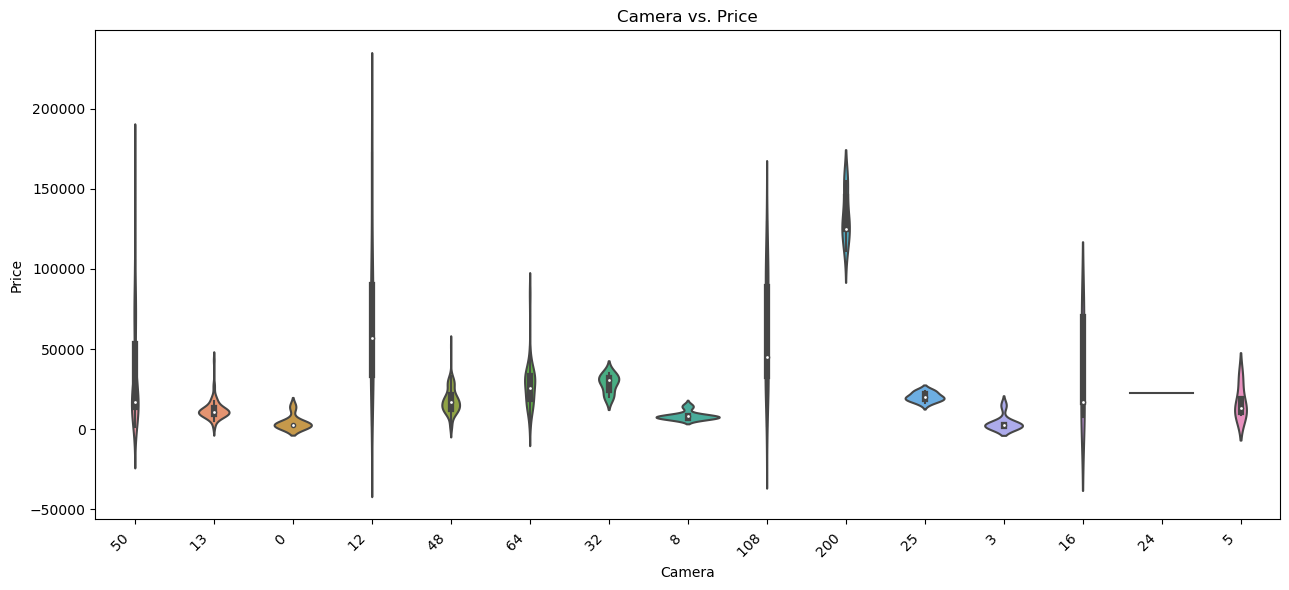

In [32]:
plt.figure(figsize=(13, 6))
sns.violinplot(x='camera', y='price', data=df)
plt.xlabel('Camera')
plt.ylabel('Price')
plt.title('Camera vs. Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Capability Vs Price

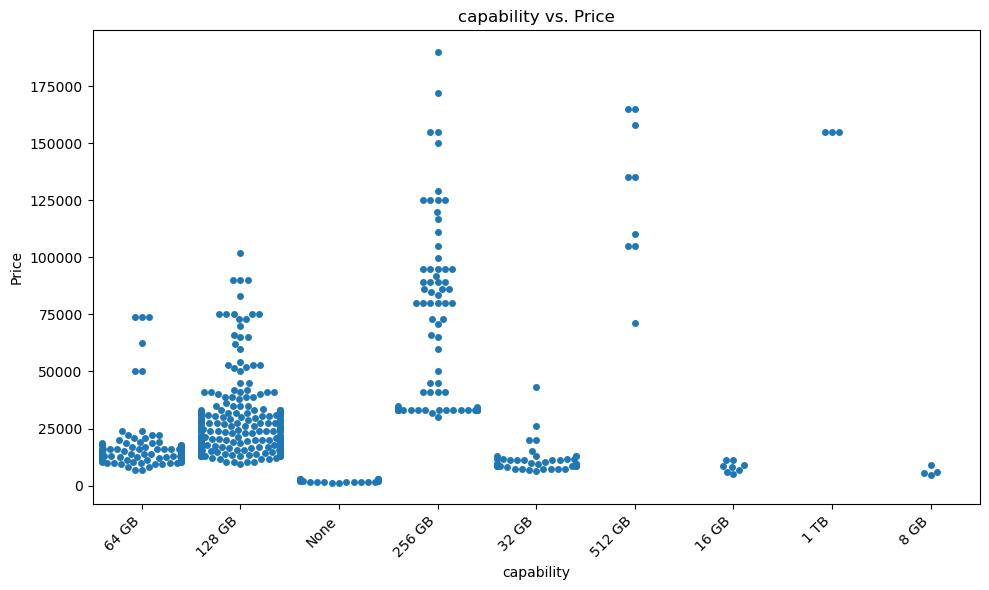

In [33]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x='capability', y='price', data=df)
plt.xlabel('capability')
plt.ylabel('Price')
plt.title('capability vs. Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Processor Type Vs Price

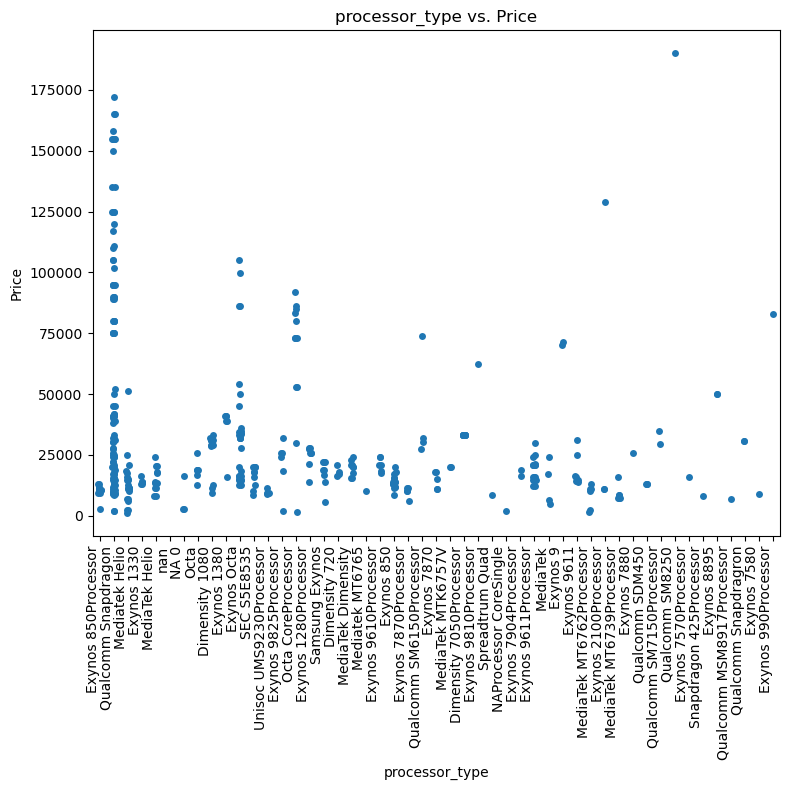

In [34]:
plt.figure(figsize=(8, 8))
sns.stripplot(x='processor_type', y='price', data=df, jitter=True)
plt.xlabel('processor_type')
plt.ylabel('Price')
plt.title('processor_type vs. Price')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


## Average Price by Battery Capacity

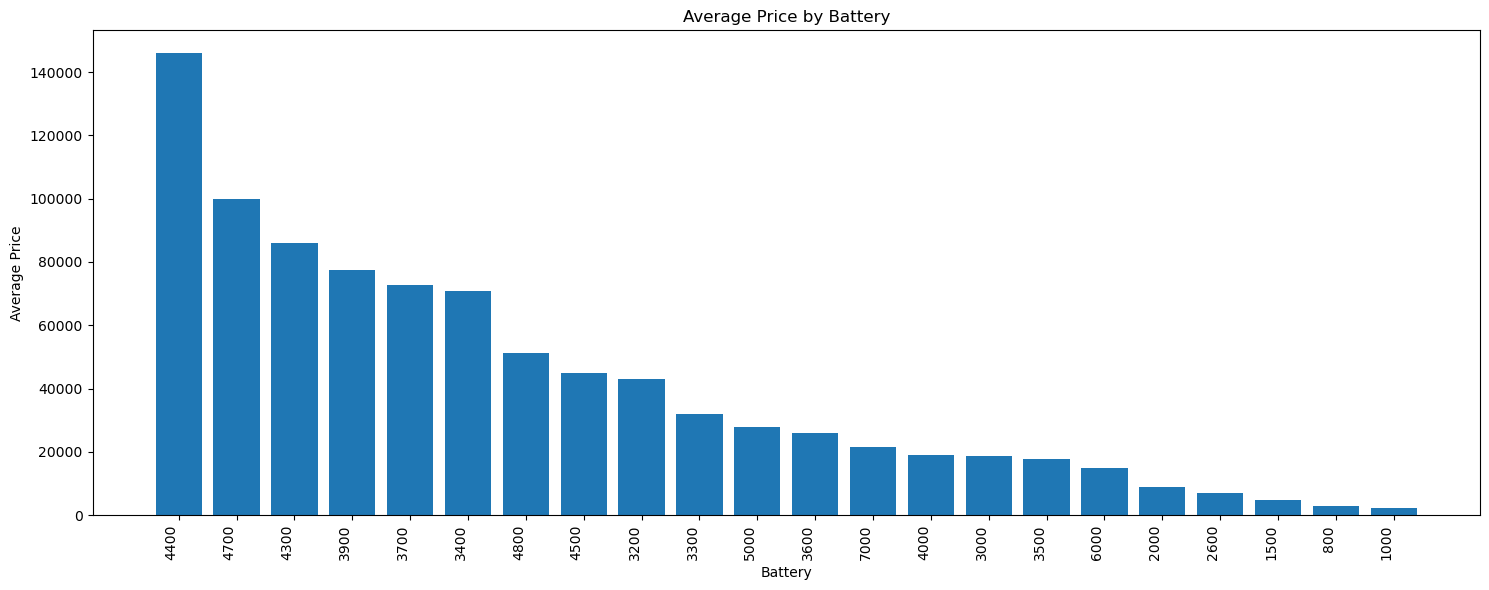

In [35]:
plt.figure(figsize=(15, 6))
avg_price_by_color = df.groupby('battery')['price'].mean().sort_values(ascending=False)
plt.bar(avg_price_by_color.index, avg_price_by_color.values)
plt.xlabel('Battery')
plt.ylabel('Average Price')
plt.title('Average Price by Battery')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


## Top 10 Average Price by Version

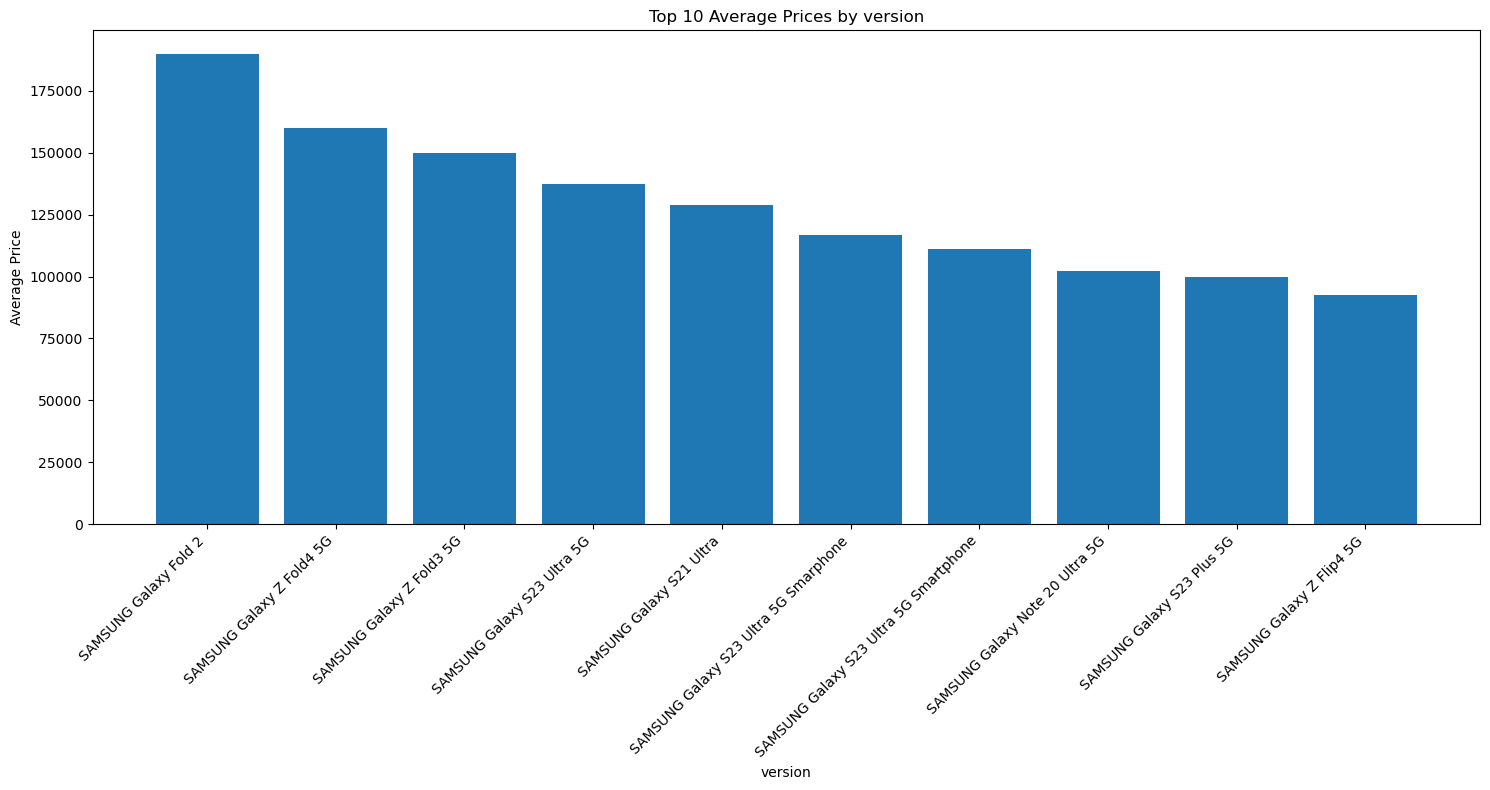

In [36]:
plt.figure(figsize=(15, 8))
avg_price_by_color = df.groupby('version')['price'].mean()
top_10_avg_price = avg_price_by_color.sort_values(ascending=False).head(10)

plt.bar(top_10_avg_price.index, top_10_avg_price.values)
plt.xlabel('version')
plt.ylabel('Average Price')
plt.title('Top 10 Average Prices by version')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Average Price by color

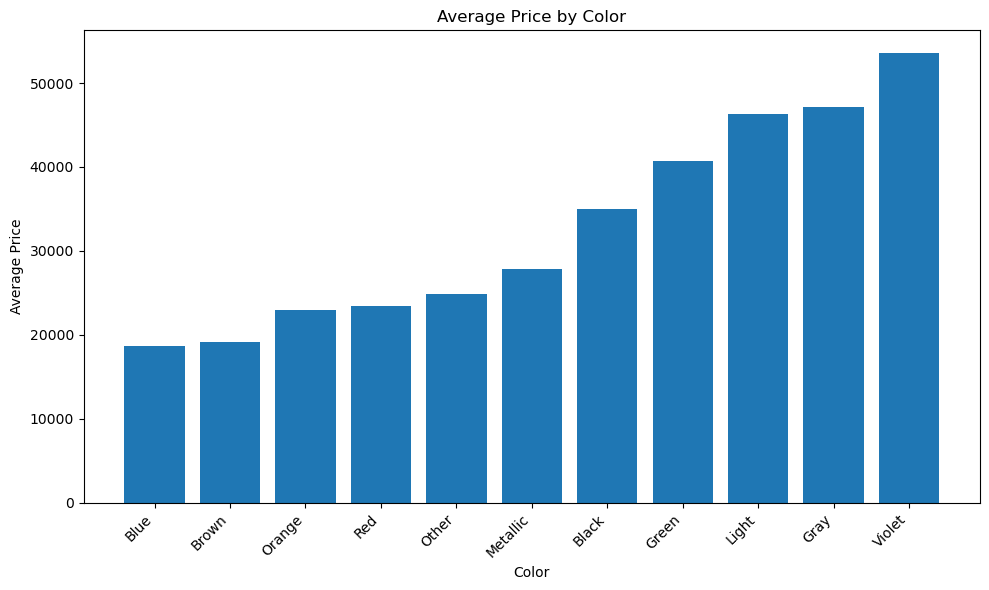

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
avg_price_by_color = df.groupby('color')['price'].mean().sort_values()
plt.bar(avg_price_by_color.index, avg_price_by_color.values)
plt.xlabel('Color')
plt.ylabel('Average Price')
plt.title('Average Price by Color')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Convert datatypes

In [38]:
df["camera"]=df["camera"].astype("float64")
df["battery"]=df["battery"].astype("float64")
df["clock_speed"]=df["clock_speed"].astype("float64")
df["display_size_cm"]=df["display_size_cm"].astype("float64")
df["display_size_inch"]=df["display_size_inch"].astype("float64")

### Ratings Vs Price

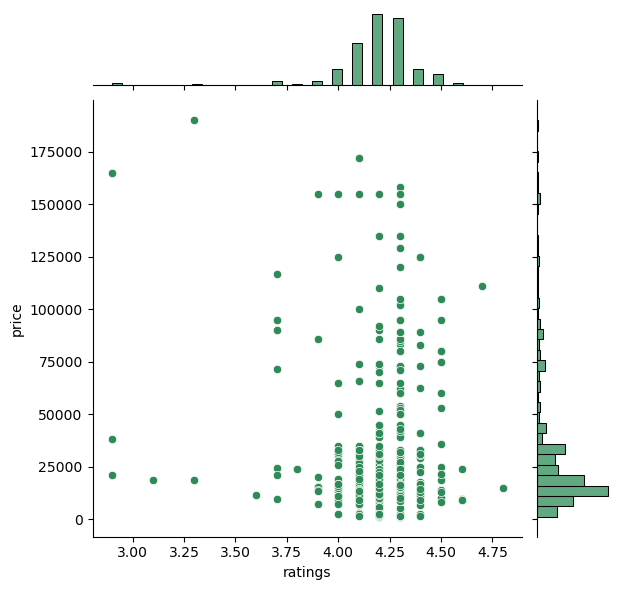

In [39]:
sns.jointplot(df,x="ratings",y="price",kind="scatter",color='seagreen')

### Correlation

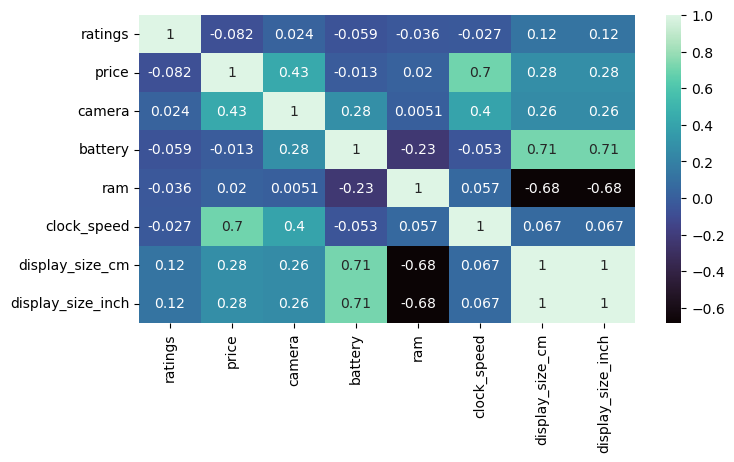

In [40]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(),annot=True,cmap="mako")
plt.show()

In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,539.0,4.197403,0.204578,2.90,4.10,4.20,4.30,4.80
price,539.0,30400.439703,31844.322104,1150.00,12704.00,17999.00,32999.00,189999.00
camera,533.0,47.013133,32.211732,0.00,16.00,50.00,64.00,200.00
battery,539.0,4647.866419,1225.825756,800.00,4350.00,5000.00,5000.00,7000.00
ram,525.0,7.636190,23.809097,0.00,4.00,6.00,8.00,512.00
clock_speed,521.0,2.304741,0.444188,1.20,2.00,2.30,2.40,3.36
display_size_cm,149.0,16.321477,1.845681,4.57,16.26,16.76,16.76,19.30
display_size_inch,149.0,6.426174,0.726654,1.80,6.40,6.60,6.60,7.60


# Missing value Imuputation

In [42]:
categorical=df.select_dtypes(include=["object"])

In [43]:
le=LabelEncoder()

for i in categorical:
    df[i]=le.fit_transform(df[i])

## KNN Imputation

In [44]:
imputer = KNNImputer(n_neighbors=2)
df_imputed = imputer.fit_transform(df)

In [45]:
column_names=df.columns
df_imputed = pd.DataFrame(df_imputed, columns=column_names)

In [46]:
df_imputed.head()

,ratings,price,camera,battery,version,color,capability,ram,processor_type,clock_speed,resolution,display_size_cm,display_size_inch
0,4.3,9499.0,50.0,6000.0,50.0,6.0,6.0,4.0,14.0,2.0,5.0,16.76,6.6
1,4.3,10499.0,50.0,6000.0,50.0,1.0,1.0,4.0,14.0,2.0,5.0,16.76,6.6
2,4.3,10499.0,50.0,6000.0,50.0,4.0,1.0,4.0,14.0,2.0,5.0,16.76,6.6
3,4.3,10499.0,50.0,6000.0,50.0,6.0,1.0,4.0,14.0,2.0,5.0,16.76,6.6
4,4.3,15499.0,50.0,5000.0,53.0,1.0,1.0,6.0,41.0,2.2,10.0,16.76,6.6


## Feature Scaling

In [47]:
# Scaling the data
df_final=scale(df_imputed)
df_final=pd.DataFrame(df_final,columns=df_imputed.columns)
df_final

,ratings,price,camera,battery,version,color,capability,ram,processor_type,clock_speed,resolution,display_size_cm,display_size_inch
0,0.501974,-0.656973,0.095037,1.104064,-0.093757,0.790959,1.273085,-0.159936,-1.163518,-0.706724,-1.598141,0.322507,0.323520
1,0.501974,-0.625541,0.095037,1.104064,-0.093757,-0.785694,-0.871268,-0.159936,-1.163518,-0.706724,-1.598141,0.322507,0.323520
2,0.501974,-0.625541,0.095037,1.104064,-0.093757,0.160298,-0.871268,-0.159936,-1.163518,-0.706724,-1.598141,0.322507,0.323520
3,0.501974,-0.625541,0.095037,1.104064,-0.093757,0.790959,-0.871268,-0.159936,-1.163518,-0.706724,-1.598141,0.322507,0.323520
4,0.501974,-0.468381,0.095037,0.287529,-0.013965,-0.785694,-0.871268,-0.083052,0.601222,-0.250541,0.481526,0.322507,0.323520
...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,1.480507,-0.280072,-0.465479,-0.937272,0.810555,-0.785694,-0.871268,-0.083052,1.058746,-0.706724,0.481526,0.276701,0.276982
535,0.501974,2.344778,1.901144,-0.120738,0.970140,1.421621,-0.013527,0.147597,-0.575271,0.958344,0.481526,0.322507,0.323520
536,0.501974,-0.446379,-0.683458,-0.529005,-0.705498,1.421621,1.273085,-0.159936,-1.294239,-1.162907,0.481526,0.276701,0.276982
537,0.991241,-0.672657,-1.057135,-1.100579,0.225412,-1.101025,0.415344,-0.236819,0.601222,-2.075273,0.481526,-0.234498,-0.234934


## Separate dependent and independent feature

In [48]:
x=df_final.drop("price",axis=1)
y=df_final["price"]

## Split train and test data 

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=7)

In [50]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((431, 12), (108, 12), (431,), (108,))

# Model Building

# Decision Tree

In [51]:
# Full decision tree model fitting
model_1=DecisionTreeRegressor(random_state=7)
model_1.fit(x_train,y_train)

DecisionTreeRegressor(random_state=7)

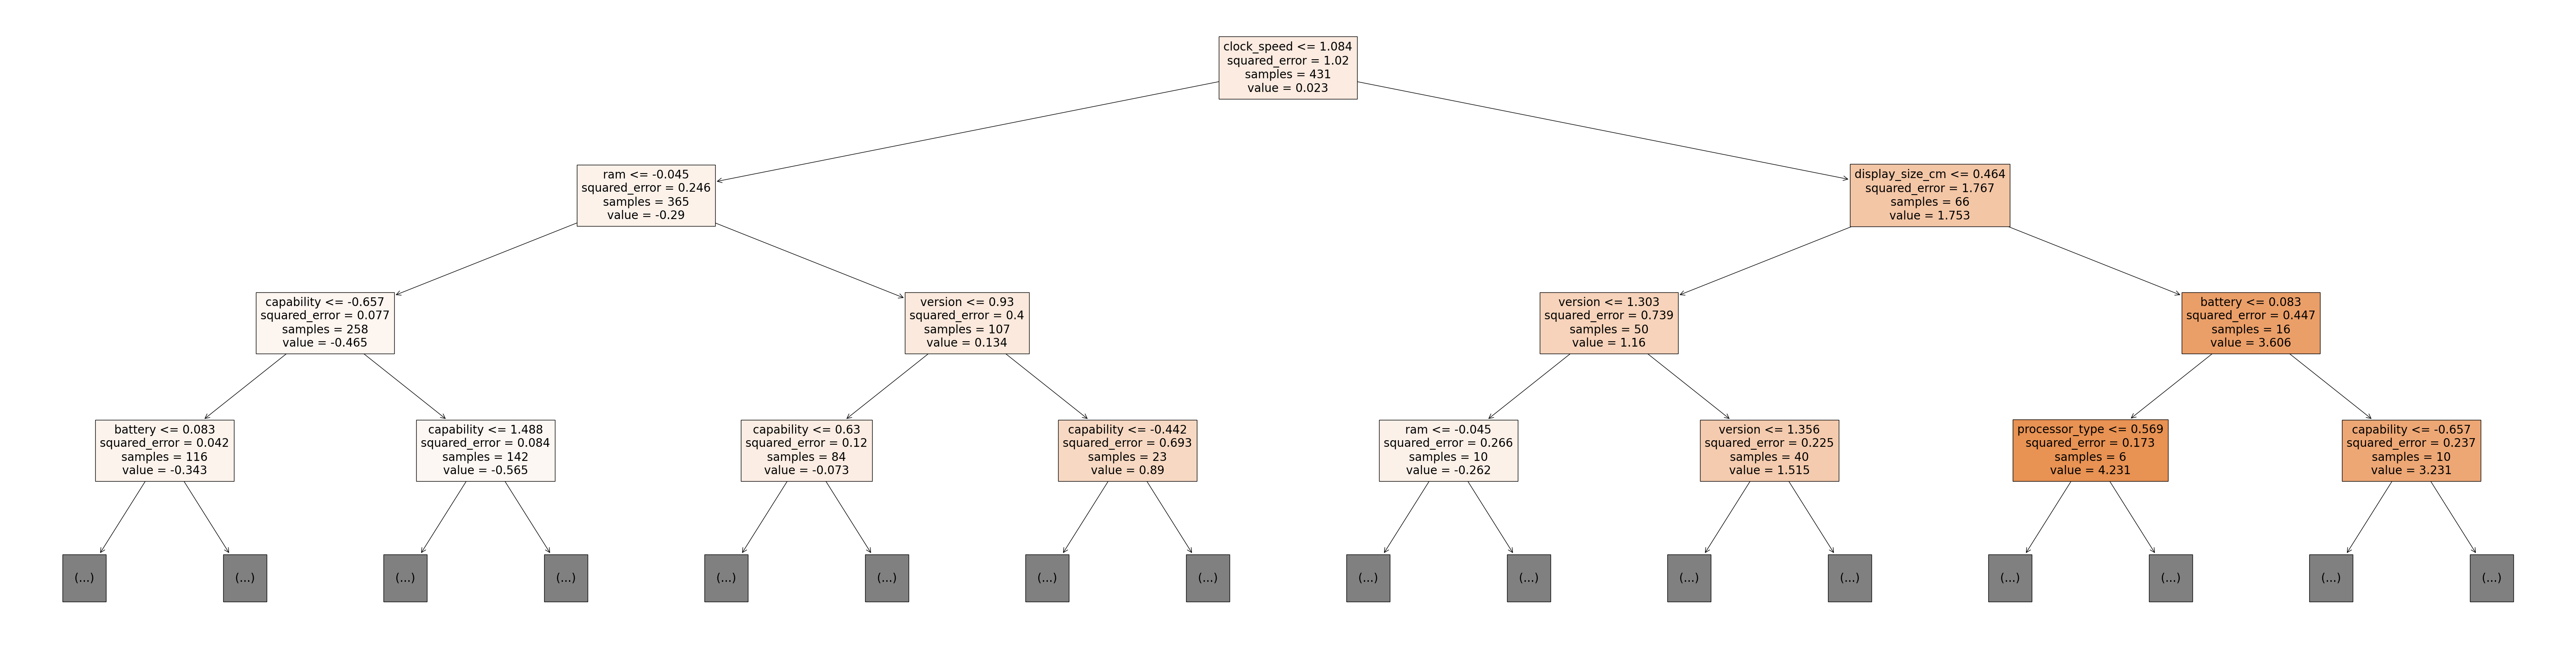

In [52]:
# Ploting Decision Tree For Max_depth =3.
plt.figure(figsize=(80,20))
plot_tree(model_1,feature_names=x_train.columns,filled=True,max_depth=3)
plt.show()

In [53]:
# Prediction for Full model
prediction=model_1.predict(x_test)
score=mean_squared_error(y_test,prediction)
score

0.05447338765899629

In [54]:
model_1.tree_.max_depth

20

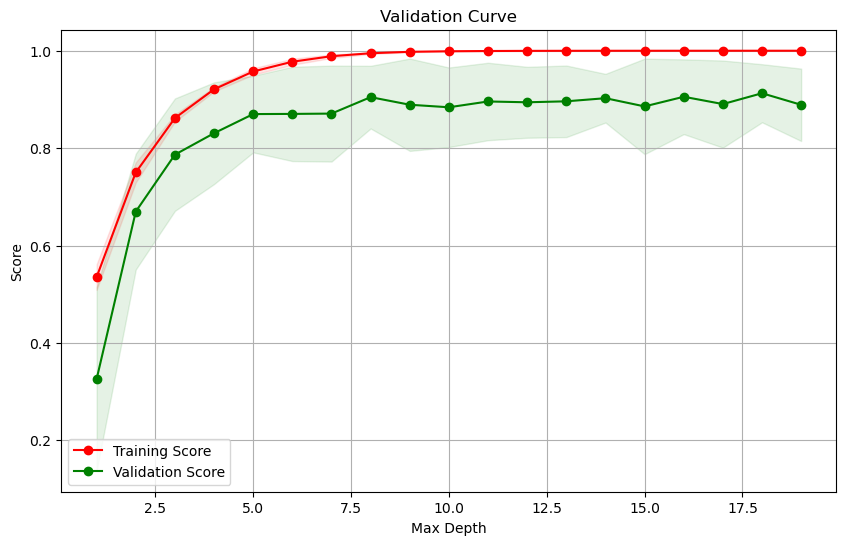

In [55]:
# Let's check the appropriate value for maximum depth
train_score, validation_score = validation_curve(DecisionTreeRegressor(),x_train,y_train,param_name="max_depth",param_range=range(1,20))

mean_train_score=np.mean(train_score,axis=1)
std_train=np.std(train_score,axis=1)
mean_validation=np.mean(validation_score,axis=1)
std_validation=np.std(validation_score,axis=1)

plt.figure(figsize=(10,6))
plt.title("Validation Curve")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.grid()

plt.plot(range(1,20),mean_train_score,"o-",color="r",label="Training Score")
plt.plot(range(1,20),mean_validation,"o-",color="g",label="Validation Score")
plt.fill_between(range(1,20),mean_train_score-std_train,mean_train_score + std_train, color="r", alpha=0.1)
plt.fill_between(range(1,20),mean_validation - std_validation, mean_validation + std_validation, color="g",alpha=0.1)

plt.legend(loc="best")
plt.show()

In [56]:
for max_dep in range(1,20):
  model=DecisionTreeRegressor(max_depth=max_dep,random_state=7)
  model.fit(x_train,y_train)
  prediction_train=model.predict(x_train)
  prediction=model.predict(x_test)
  print("Training score of max_depth {} is".format(max_dep),mean_squared_error(y_train,prediction_train))
  print("Prediction Score of max_depth {} is".format(max_dep), mean_squared_error(y_test,prediction))
  print(" ")

Training score of max_depth 1 is 0.4791006817755372
Prediction Score of max_depth 1 is 0.3915356414003433
 
Training score of max_depth 2 is 0.24787309811783012
Prediction Score of max_depth 2 is 0.2237729022745462
 
Training score of max_depth 3 is 0.13431519765281286
Prediction Score of max_depth 3 is 0.18438341773564504
 
Training score of max_depth 4 is 0.0737310378449081
Prediction Score of max_depth 4 is 0.12923083694199092
 
Training score of max_depth 5 is 0.04984684807999745
Prediction Score of max_depth 5 is 0.11651334669784326
 
Training score of max_depth 6 is 0.030007669043879186
Prediction Score of max_depth 6 is 0.09537423762074836
 
Training score of max_depth 7 is 0.01029102335709643
Prediction Score of max_depth 7 is 0.0756935946006916
 
Training score of max_depth 8 is 0.004747215282830907
Prediction Score of max_depth 8 is 0.07319794325240558
 
Training score of max_depth 9 is 0.0021627754127108317
Prediction Score of max_depth 9 is 0.06963112817554576
 
Training sc

In [57]:
# Create the Decision Tree Regressor model with specified max_depth and random_state
model_2 = DecisionTreeRegressor(max_depth=11, random_state=7)

# Fit the model to the training data (x_train: features, y_train: target variable)
model_2.fit(x_train, y_train)

# Use the fitted model to make predictions on the test data
prediction = model_2.predict(x_test)

# Calculate the Mean Squared Error (MSE) and R-squared (R^2) scores for evaluation
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)

# Print the evaluation scores
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 0.06823136324746149
R-squared: 0.9249312500493659


# Random Forest

In [58]:
# Create the Random Forest Regressor model with specified hyperparameters
model_3 = RandomForestRegressor(n_estimators=150, max_depth=11, random_state=7, n_jobs=-1, max_features=None)

# Fit the model to the training data (x_train: features, y_train: target variable)
model_3.fit(x_train, y_train)

# Use the fitted model to make predictions on the test data
prediction = model_3.predict(x_test)

# Calculate the Mean Squared Error (MSE) and R-squared (R^2) scores for evaluation

mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)

# Print the evaluation scores
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 0.043114050629516065
R-squared: 0.9525655397748991


# SVR

In [59]:
# Create an SVR model
svr_model = SVR()

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10],                    
    'kernel': ['linear', 'rbf', 'poly'], 
    'gamma': [0.1, 1, 'scale', 'auto'],  
    'epsilon': [0.1, 0.2, 0.3],    
}

# Create the GridSearchCV object
grid_search = GridSearchCV(svr_model, param_grid, cv=5)

# Fit the data to find the best hyperparameters
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best SVR model
best_svr_model = grid_search.best_estimator_

# Evaluate the model on the test data
score = best_svr_model.score(x_test, y_test)
print("Test Score (R^2):", score)


Best Hyperparameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Test Score (R^2): 0.8487673447235051


##  Thank You !